# Hands-on Machine Learning
# Chapter 4 - Training Models

## Setup

In [3]:
# Is Python version at least 3.5?
import sys
assert sys.version_info >= (3, 5)

# Is sklearn at least version 0.2?
import sklearn
assert sklearn.__version__  >= "0.20"

# Helper libraries
import numpy as np
import pandas as pd

# Matplotlib setup 
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib as mpl
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Ignore warnings for this notebook
import warnings
warnings.filterwarnings(action='ignore', message='^internal gelsd')

In [5]:
# Directory for storing images
import os
PROJECT_ROOT_DIR = "../"
CHAPTER_ID = '04_training_linear_models'
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, 'images', CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

In [6]:
# Function save images
def save_fig(fig_id, tight_layout=True, fig_extension='png', resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + '.' + fig_extension)
    print("Saving figure ", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

## Example 1 - Normal Equation and Linear Models
The normal equation provides a closed-form solution for minimising the parameter values $\theta$ of a linear model to minimise the mean square error between the model's predictions $y'$ and $y$.

In [9]:
# Create a domain of 100 random values between 0 and 1
X = 2 * np.random.rand(100, 1)

# Use this domain to create a linear sum with some normally distributed noise
y = 4 + 3 * X + np.random.randn(100, 1)

Saving figure  01_generated_data_plot


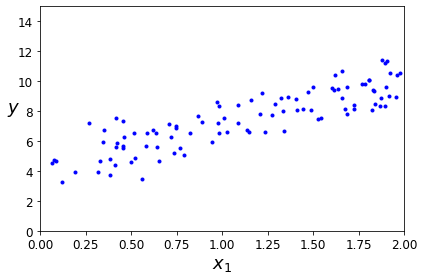

In [11]:
# Create a scatter plot of the randomly generated data
plt.plot(X, y, 'b.')
plt.xlabel('$x_1$', fontsize=18)
plt.ylabel('$y$', rotation=0, fontsize=18)
plt.axis([0, 2, 0, 15]) # Axis limits
save_fig('01_generated_data_plot')

Will now compute the values of $\theta$ for this dataset using the normal equation to prove that it does, indeed, derive the correct values. `np.linalg.inv` is used to invert the matrix and `dot` is used for matrix multiplication in the evaluation of  $$\theta^{'} = (X^{T}X)^{-1}X^{T}y$$

In [12]:
# Add the bias feature x_0 = 1 to all rows in X
X_b = np.c_[np.ones((100, 1)), X]

In [13]:
# Use the normal equation to find the values of theta for this model
theta_best = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(y)

In [14]:
theta_best

array([[4.22356039],
       [2.9203829 ]])

The reason why the normal equation does not predict exactly 4 and 3 is because we have added random noise to the value computed by the original function.

In [18]:
# Create new instances on which to test the normal equation
X_new = np.array([[0], [2]])

# Add x_0 = 1 to each instance
X_new_b = np.c_[np.ones((2, 1)), X_new] 

# Make predictions
y_predict = X_new_b.dot(theta_best)
y_predict

array([[ 4.22356039],
       [10.0643262 ]])

Saving figure  02_linear_model_predictions_plot


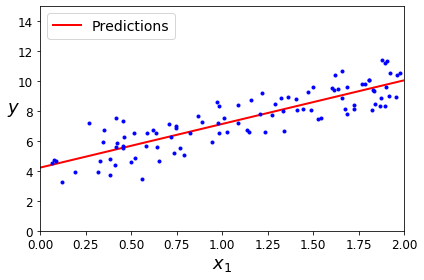

In [23]:
# Plot the model's predictions for all values in the domain
plt.plot(X_new, y_predict, 'r-', label='Predictions', linewidth=2)

# Original scatterplot data
plt.plot(X, y, 'b.')

plt.axis([0, 2, 0, 15])
plt.xlabel('$x_1$', fontsize=18)
plt.ylabel('$y$', fontsize=18, rotation=0)
plt.legend(loc='upper left', fontsize=14)
save_fig('02_linear_model_predictions_plot')
plt.show()

## Example 2 - Linear Regression with `sklearn`

In [26]:
from sklearn.linear_model import LinearRegression

In [27]:
lin_reg = LinearRegression()

In [28]:
# Computes the values of theta_0 and theta_1 that minimise MSE for X
lin_reg.fit(X, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [29]:
# Output the learnt params 
print("Intercept: ", lin_reg.intercept_)
print("Coefficients: ", lin_reg.coef_)

Intercept:  [4.22356039]
Coefficients:  [[2.9203829]]


In [30]:
# Make predictions on new data using the linear regression model
lin_reg.predict(X_new)

array([[ 4.22356039],
       [10.0643262 ]])

 Under the hood, the `LinearRegression.fit()` method calls the least squares minimising function built into `scipy`, which we can call directly. It returns the least squares solution to a linear matrix equation.

In [31]:
theta_best_svd, residuals, rank, s = np.linalg.lstsq(X_b, y, rcond=1e-6)

In [32]:
theta_best_svd

array([[4.22356039],
       [2.9203829 ]])

Gives the same results as the linear regression function, but at a lower level of abstraction. Also, doesn't compute the inverse, but rather the pseudoinverse of X. The equation it solves is $$\theta^{'} = X^{+}y$$ where $X^{+}$ is the pseudoinverse of $X$.

In [35]:
# Can compute pseudoinverse and its dot product with y directly
np.linalg.pinv(X_b).dot(y)

array([[4.22356039],
       [2.9203829 ]])

### Pseudoinverse vs Inverse
Pseudoinverse computation is done using **singular value decomposition (SVD)**, which decomposes a training set matrix **X** into the multiplication of three matrices $U$, $\Sigma$, $V^{T}$. 

The pseudoinverse uses $X^{+} = V \Sigma^{+}U^{T}$. To compute $Sigma^+$, the algorithm will set to 0 all values in $\Sigma$ that are lower than a specified threshold. Non-zero values are replaced with their inverses. The resulting matrix is then transposed. 

This provides a more **computationally efficient approach** than computing the actual inverse as in the normal equation, and also handles edge cases very wel. 